# Text classification using pretrained tensorflow embedding model 

In [1]:
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub

%matplotlib inline

# Importing and Preprocessing data

In [2]:
# importing the data and prinitng few rows to examine the data
# read the CSV file 
df = pd.read_csv("codeset.csv", header=None) 
   
# print the first five rows 
print(df.head())

      0     1           2                                     3    4    5   \
0  37013  AFIB   314208002             Rapid atrial fibrillation  NaN  NaN   
1  37014  Afib  3320796013                        Atrial flutter  NaN  NaN   
2  37015  Afib  3322864015               Atypical atrial flutter  NaN  NaN   
3  37016  AFib   421232012   AF - Paroxysmal atrial fibrillation  NaN  NaN   
4  37017  Afib   421233019  PAF - Paroxysmal atrial fibrillation  NaN  NaN   

    6   7   8   9  10         11  12  13  14    15 16  \
0  NaN NaN NaN NaN  f  SNOMED-CT  74 NaN NaN  4010  f   
1  NaN NaN NaN NaN  f  SNOMED-CT  74 NaN NaN  4010  f   
2  NaN NaN NaN NaN  f  SNOMED-CT  74 NaN NaN  4010  f   
3  NaN NaN NaN NaN  f  SNOMED-CT  74 NaN NaN  4010  f   
4  NaN NaN NaN NaN  f  SNOMED-CT  74 NaN NaN  4010  f   

                                     17  
0  3137fbd7-551e-4e7e-96f8-13b12a867098  
1  3137fbd7-551e-4e7e-96f8-13b12a867098  
2  3137fbd7-551e-4e7e-96f8-13b12a867098  
3  3137fbd7-551e-4e7

In [3]:
# selecting only the columns present in the problem statement
select_columns_index = [3,15]
df = df.iloc[:,select_columns_index]

In [4]:
# dropping the rows with empty values i.e. incomplete data
df = df.dropna()
print(df.shape)

(32052, 2)


In [5]:
# renaming the columns for better readability 
df = df.rename(columns={3: "symptoms", 15: "code"})
df.head()


,symptoms,code
0,Rapid atrial fibrillation,4010
1,Atrial flutter,4010
2,Atypical atrial flutter,4010
3,AF - Paroxysmal atrial fibrillation,4010
4,PAF - Paroxysmal atrial fibrillation,4010


In [6]:
def create_labels_df(df, label_column):
    # create numerical lables for training the data 
    df["label"] = np.nan
#     print(df.shape)

    value_counts = df[label_column].value_counts() # Specific column 
    code_index   = value_counts.index
#     print(code_index)
    for i, code_id in enumerate(code_index):
        df.loc[df[df[label_column] == code_id].index,"label"] = i
        
    return df

In [7]:
# train and test split https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        #print('\n%s:\n---------\ntotal:%d\ntrain_df:%d\ntest_df:%d' % (lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)))
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)

    return train_df, test_df

In [8]:
def data_processing(df, threshold):    
    # reducing the problem to 10 classes
    value_counts = df["code"].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= threshold].index
    for code in to_remove:
        df = df[df["code"] != code]

    df =  create_labels_df(df,"code")

    train_df, test_df = split_to_train_test(df, "label", train_frac=0.8)
    
    return train_df, test_df

In [9]:
# selecting only 10 classes to experiment with 
train_df, test_df = data_processing(df,650) 

## plotting confusion_matrix block

In [10]:
import seaborn as sns
from sklearn import metrics

In [11]:
def plot_confusion_matrix(score, true_labels, predicted_labels, n_labels):
    confusion_matrix = metrics.confusion_matrix(true_labels,predicted_labels)
    plt.figure(figsize=(n_labels-1,n_labels-1))
    sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

## Load the pretrained tensorflow word embedding model 

In [12]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [13]:
# load test and train data
x_train = train_df["symptoms"].to_numpy()
y_train = train_df["label"].to_numpy()

x_test = test_df["symptoms"].to_numpy()
y_test = test_df["label"].to_numpy()

In [14]:
print(x_train.shape, y_train.shape, )

(15712,) (15712,)


## Testing model 1 with embedding size 20

Here the hub layer takes the text data and converts it into a array of size 20

In [15]:

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation ='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 400,526
Trainable params: 400,526
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [17]:
model.fit(x_train, y_train, epochs=20)

Train on 15712 samples
Epoch 1/20
15712/15712 [==============================] - 3s 163us/sample - loss: 2.1493 - accuracy: 0.3429
Epoch 2/20
15712/15712 [==============================] - 2s 132us/sample - loss: 2.0594 - accuracy: 0.3975
Epoch 3/20
15712/15712 [==============================] - 2s 144us/sample - loss: 2.0262 - accuracy: 0.4276
Epoch 4/20
15712/15712 [==============================] - 2s 145us/sample - loss: 2.0149 - accuracy: 0.4328
Epoch 5/20
15712/15712 [==============================] - 2s 150us/sample - loss: 2.0075 - accuracy: 0.4381
Epoch 6/20
15712/15712 [==============================] - 2s 152us/sample - loss: 1.9987 - accuracy: 0.4792
Epoch 7/20
15712/15712 [==============================] - 2s 141us/sample - loss: 1.9904 - accuracy: 0.5170
Epoch 8/20
15712/15712 [==============================] - 2s 142us/sample - loss: 1.9825 - accuracy: 0.5260
Epoch 9/20
15712/15712 [==============================] - 2s 137us/sample - loss: 1.9744 - accuracy: 0.5291
Epoch

3926/1 - 0s - loss: 2.1973 - accuracy: 0.5247


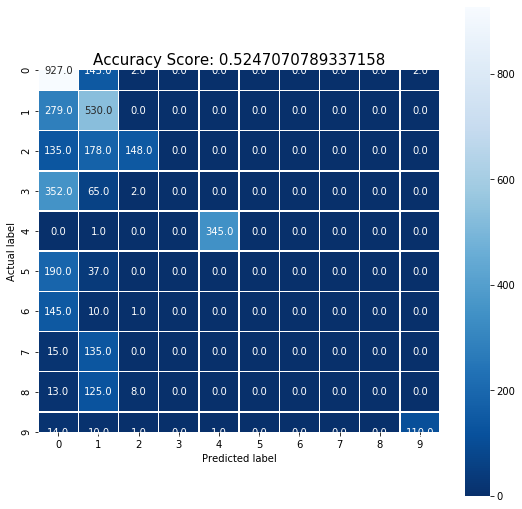

In [18]:
_, accuracy = model.evaluate(x_test,  y_test, verbose=2)
predictions = np.argmax(model.predict(x_test), axis=1)
plot_confusion_matrix(accuracy, y_test, predictions, 10)

## Testing model 2 with embedding size of 128

In [19]:
embedding_128 = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer_128 = hub.KerasLayer(embedding_128, input_shape=[], 
                           dtype=tf.string, trainable=True)


In [20]:
model_128 = tf.keras.Sequential()
model_128.add(hub_layer)
model_128.add(tf.keras.layers.Dense(128, activation='relu'))
model_128.add(tf.keras.layers.Dense(64, activation='relu'))
model_128.add(tf.keras.layers.Dense(32, activation='relu'))
model_128.add(tf.keras.layers.Dense(10, activation ='softmax'))

model_128.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 413,374
Trainable params: 413,374
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_128.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model_128.fit(x_train, y_train, epochs=20)

Train on 15712 samples
Epoch 1/20
15712/15712 [==============================] - 3s 159us/sample - loss: 2.0470 - accuracy: 0.4179
Epoch 2/20
15712/15712 [==============================] - 2s 130us/sample - loss: 2.0074 - accuracy: 0.4425
Epoch 3/20
15712/15712 [==============================] - 2s 129us/sample - loss: 1.9777 - accuracy: 0.4899
Epoch 4/20
15712/15712 [==============================] - 2s 130us/sample - loss: 1.9360 - accuracy: 0.5311
Epoch 5/20
15712/15712 [==============================] - 2s 135us/sample - loss: 1.9303 - accuracy: 0.5316
Epoch 6/20
15712/15712 [==============================] - 2s 129us/sample - loss: 1.9302 - accuracy: 0.5314
Epoch 7/20
15712/15712 [==============================] - 2s 127us/sample - loss: 1.9296 - accuracy: 0.5317
Epoch 8/20
15712/15712 [==============================] - 2s 149us/sample - loss: 1.9295 - accuracy: 0.5318
Epoch 9/20
15712/15712 [==============================] - 2s 137us/sample - loss: 1.9294 - accuracy: 0.5318
Epoch

3926/1 - 0s - loss: 2.2437 - accuracy: 0.4350


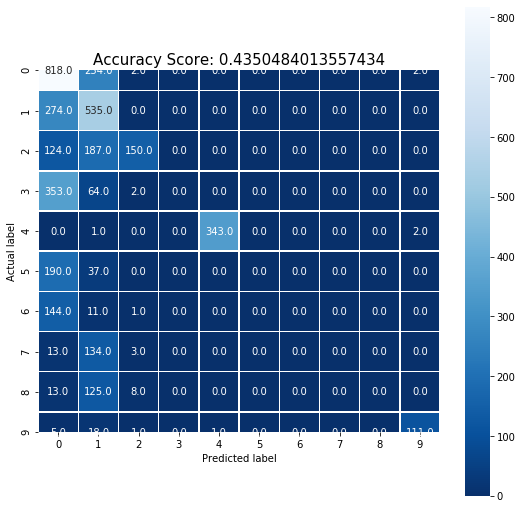

In [23]:
_, accuracy = model_128.evaluate(x_test,  y_test, verbose=2)
predictions = np.argmax(model.predict(x_test), axis=1)
plot_confusion_matrix(accuracy, y_test, predictions, 10)

# Inference 
Here the pretrained models from tensorflow might not have been trained on the medical data in the problem dataset. That might be the reason of poor purformance (have to double check, Did not get a chance to completely observe the data set that the pretrained model is trained on). But with more data these kind of embeddings can be trained which might learn complex reprecentation of the text and the performance can be compared to the existing bag of words models.